# Assignment 5

- M Nikhil Bharat (17EE223)
- Russel Shawn Dsouza (171EC143)

## Setup

##### Imports

In [ ]:
import os
import shutil
import glob
import itertools
from zipfile import ZipFile
from tqdm.notebook import tqdm, trange
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow import keras as K
from keras import layers as L

Connect Google Drive

In [ ]:
all_dataset_dir = Path('data')
%mkdir data/

my_gdrive_dir   = Path('/gdrive/My Drive/Sem 7/nn & dl/assignments/assignment-05')
from google.colab import drive
drive.mount('/gdrive')

mkdir: cannot create directory ‘data/’: File exists
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Connect Kaggle

In [ ]:
from getpass import getpass
import json

kaggle_json_dir = Path('/root/.kaggle')
if (kaggle_json_dir / 'kaggle.json').is_file():
    print("Kaggle JSON exists. S")
kaggle_json = {"username": getpass("Enter kaggle username: "), "key": getpass("Enter kaggle API key: ")}
kaggle_json_dir.mkdir(parents=True, exist_ok=True)
with open(kaggle_json_dir / 'kaggle.json', 'w') as f:
    json.dump(kaggle_json, f)

%cat /root/.kaggle/kaggle.json

##### Utils

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.backend.sum(K.backend.round(K.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.backend.sum(K.backend.round(K.backend.clip(y_true, 0, 1)))
    predicted_positives = K.backend.sum(K.backend.round(K.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.backend.epsilon())
    recall = true_positives / (possible_positives + K.backend.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.backend.epsilon())
    return f1

## Q1

**AlexNet on Steel-Defect-Detection**

##### Download custom 256x256 single defect dataset

In [ ]:
%%shell
if [ -d "/content/data/severstal-steel-defect-detection-custom" ]; then
    echo "Directory exists. Skipping creation..."
else
    mkdir -p 'data/severstal-steel-defect-detection-custom'
fi

cd 'data/severstal-steel-defect-detection-custom'

if [ -f "/content/data/severstal-steel-defect-detection-custom/severstal-256x256-images-with-defects.zip" ]; then
    echo "Dataset zip has been downloaded. Skipping download..."
else
    kaggle datasets download -d iafoss/severstal-256x256-images-with-defects
fi

if [ -d '/content/data/severstal-steel-defect-detection-custom/masks' ]; then
    echo "Dataset unzipped. Skipping extraction..."
else
    unzip -q 'severstal-256x256-images-with-defects.zip'
fi
cd ..

In [ ]:
current_dataset_dir = all_dataset_dir / 'severstal-steel-defect-detection-custom'

cols, rows = 4,4
fig=plt.figure(figsize=(cols*4, rows*4))

fnames = sorted(os.listdir(current_dataset_dir / 'images'))[8:]
for i in range(rows):
    for j in range(cols):
        idx = i + j*cols
        img = Image.open(current_dataset_dir / 'images' / fnames[idx]).convert('RGB')
        mask = Image.open(current_dataset_dir / 'masks' / fnames[idx])#.convert('LA')

        fig.add_subplot(rows, cols, idx+1)
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(mask, alpha=0.2)
plt.show()

##### Download original 1600x256 multi-label dataset

In [ ]:
# Constants for Original dataset
current_dataset_dir = all_dataset_dir / 'severstal-steel-defect-detection'
current_dataset_dir.mkdir(parents=True, exist_ok=True)
BATCH_SIZE = 4
IMAGE_SIZE = (256, 1600)

# Copy dataset into data/ from GDrive
zippath = shutil.copyfile(my_gdrive_dir / 'severstal-steel-defect-detection.zip',
                          current_dataset_dir / 'severstal-steel-defect-detection.zip')

# Extract dataset
cwd = Path.cwd()
os.chdir(zippath.parents[0])
with ZipFile(zippath.name, 'r') as zf:
    zf.extractall()
os.chdir(cwd)

# Read original CSV
df = pd.read_csv(current_dataset_dir / 'train.csv')
df.head()

# Convert CSV to dict
steelDict = {}
for i, row in df.iterrows():
    if row.ImageId not in steelDict.keys():
        steelDict[row.ImageId] = df[df.ImageId == row.ImageId].ClassId

# Create label encoder
mlb = MultiLabelBinarizer()
mlb.fit(steelDict.values())
print(f'Classes found: {mlb.classes_}')
print(f'Sample transform: [3, 4] => {mlb.transform([(3, 4)])}')

# One hot encode labels
for k, v in steelDict.items():
    steelDict[k] = list(itertools.chain.from_iterable(mlb.transform([v])))

# Create new df
dfFromDict = pd.DataFrame(data=steelDict.items())
dfFromDict.columns = ['ImageId', 'ClassArray']
dfFromDict.head()

NameError: ignored

In [ ]:
len(dfFromDict.ImageId.unique()) == len(dfFromDict)

NameError: ignored

##### Data Generator

[1 0 0 0]


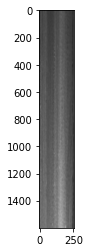

In [ ]:
class SeverstalSteelSequence(K.utils.Sequence):
    def __init__(self, df, root, batch_size, image_size):
        self.df = df
        self.root = root
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        # https://stackoverflow.com/a/63428110
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch   = self.df.loc[idx*self.batch_size : (idx + 1)*self.batch_size]
        batch_x = [Path(self.root) / str(imageId) for imageId in batch.ImageId]
        batch_x = np.asarray([np.asarray(Image.open(fname).resize(self.image_size)) for fname in batch_x], dtype=np.float32) / 255.
        batch_y = np.asarray([np.asarray(classArray, dtype=np.uint8) for classArray in batch.ClassArray])

        return batch_x, batch_y


ds = SeverstalSteelSequence(dfFromDict, current_dataset_dir / 'train_images', BATCH_SIZE, IMAGE_SIZE)
print(ds[0][1][0])
plt.imshow(ds[0][0][0])
plt.show()

In [ ]:
ds[0][0].dtype, ds[0][1].dtype, ds[0][0].max()

(dtype('float32'), dtype('uint8'), 1.0)

##### Model

In [ ]:
def AlexNet(input_shape, classes, finalAct='sigmoid'):
    layers = [
        L.Conv2D(filters=96, input_shape=input_shape, kernel_size=(11, 11), strides=(4, 4), padding='valid'),
        L.Activation('relu'),
        L.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
        L.normalization.BatchNormalization(),

        L.Conv2D(filters=256, kernel_size=(11, 11), strides=(1, 1), padding='valid'),
        L.Activation('relu'),
        L.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
        L.normalization.BatchNormalization(),

        L.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'),
        L.Activation('relu'),
        L.normalization.BatchNormalization(),

        L.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'),
        L.Activation('relu'),
        L.normalization.BatchNormalization(),

        L.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='valid'),
        L.Activation('relu'),
        L.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
        L.normalization.BatchNormalization(),

        L.Flatten(),
        L.Dense(4096, input_shape=(input_shape[0] * input_shape[1] * input_shape[2], )),
        L.Activation('relu'),
        L.Dropout(0.4),
        L.normalization.BatchNormalization(),

        L.Dense(4096),
        L.Activation('relu'),
        L.Dropout(0.4),
        L.normalization.BatchNormalization(),

        L.Dense(1000),
        L.Activation('relu'),
        L.Dropout(0.4),
        L.normalization.BatchNormalization(),

        L.Dense(classes),
        L.Activation(finalAct)  # Multi-label classification => Sigmoid
    ]
    return K.models.Sequential(layers)

model = AlexNet(input_shape=(*IMAGE_SIZE, 3), classes=len(mlb.classes_), finalAct='sigmoid')
model.compile(loss='binary_crossentropy',
              optimizer=K.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy', f1_score, K.metrics.MeanIoU(num_classes=len(mlb.classes_))])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 398, 96)       34944     
_________________________________________________________________
activation (Activation)      (None, 62, 398, 96)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 199, 96)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 199, 96)       384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 189, 256)      2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 21, 189, 256)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 94, 256)       0

##### Training

In [ ]:
traindf, validdf = train_test_split(dfFromDict, test_size=0.2, random_state=42)
traindf.shape, validdf.shape

((5332, 2), (1334, 2))

In [ ]:
traingen = SeverstalSteelSequence(traindf, current_dataset_dir / 'train_images', BATCH_SIZE, IMAGE_SIZE)
validgen = SeverstalSteelSequence(validdf, current_dataset_dir / 'train_images', BATCH_SIZE, IMAGE_SIZE)
history = model.fit(traingen,
                    validation_data=validgen,
                    # epochs=250,
                    verbose=1)

NameError: ignored

In [ ]:
plt.plot(history.history['loss'])

##### Inference

In [ ]:
Y_test_hat = model.predict(x=validgen, batch_size=BATCH_SIZE, verbose=1)
# sns.heatmap(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_test_hat, axis=1)), cmap="Greens")

KeyError: ignored

## Q2

**VGG16 on Breast-histopathology-images**

##### Download dataset from Kaggle

In [1]:
%%shell
chmod 600 /root/.kaggle/kaggle.json
mkdir -p data/breast-histopathology-images
cd data/breast-histopathology-images
kaggle datasets download -d paultimothymooney/breast-histopathology-images
unzip -q breast-histopathology-images.zip
rm breast-histopathology-images.zip
cd ../..

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open breast-histopathology-images.zip, breast-histopathology-images.zip.zip or breast-histopathology-images.zip.ZIP.
rm: cannot remove 'breast-histopathology-images.zip': No such file or directory


##### Rearrange dataset

In [2]:
base_path = dataset_dir / 'breast-histopathology-images' / 'IDC_regular_ps50_idx5'
pr_path = dataset_dir / 'breast-histopathology-processed'
pr_path_0 = pr_path / '0'
pr_path_0.mkdir(parents=True, exist_ok=True)
pr_path_1 = pr_path / '1'
pr_path_1.mkdir(parents=True, exist_ok=True)

folder_list = os.listdir(base_path)

total_images = 0
for n in range(len(folder_list)):
    patient_id = folder_list[n]
    for c in [0, 1]:
        subfiles = os.listdir(base_path / patient_id / str(c))
        total_images += len(subfiles)
print(f"Found {total_images} images.")

pbar = trange(total_images, desc='Rearranging directory structure')
for patient_id in folder_list:
    for c in [0, 1]:
        class_path = base_path / patient_id / str(c)
        for sf in class_path.glob('*.*'):
            shutil.copy(sf, pr_path / str(c) / sf.name)
            pbar.update()

# 🎉
len(os.listdir(pr_path_0)) + len(os.listdir(pr_path_1)) == total_images

NameError: ignored

##### Data Generators

In [ ]:
train_ds = K.preprocessing.image_dataset_from_directory(
    pr_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(50, 50),
    batch_size=64,
)
val_ds = K.preprocessing.image_dataset_from_directory(
    pr_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(50, 50),
    batch_size=64,
)

train_ds = train_ds.prefetch(buffer_size=64)
val_ds   = val_ds.prefetch(buffer_size=64)

data_augmentation = K.Sequential(
    [
        L.experimental.preprocessing.Rescaling(1.0 / 255.0),
        L.experimental.preprocessing.RandomFlip("horizontal"),
        L.experimental.preprocessing.RandomFlip("vertical"),
        L.experimental.preprocessing.RandomRotation(0.1),
    ]
)

##### Model

In [ ]:
"""VGG16 model in Keras

# Reference
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](
    https://arxiv.org/abs/1409.1556) (ICLR 2015)

"""

def VGG16(include_top=True, input_tensor=None, pooling=None, classes=1000):
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not K.backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = L.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = L.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = L.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = L.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = L.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = L.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = L.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = L.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = L.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = L.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = L.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = L.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = L.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = L.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = L.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = L.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = L.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
    x = L.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = L.Flatten(name='flatten')(x)
        x = L.Dense(4096, activation='relu', name='fc1')(x)
        x = L.Dense(4096, activation='relu', name='fc2')(x)
        x = L.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = L.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = L.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = K.utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='vgg16')

    return model

model = VGG16(input_shape=(50, 50, 3), classes=1)
model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy', K.metrics.MeanIoU(num_classes=4)])
model.summary()

##### Training

In [ ]:
epochs = 250

callbacks = [
    K.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

##### Inference

In [ ]:
Y_test_hat = model.predict(X_test)
sns.heatmap(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_test_hat, axis=1)), cmap="Greens")

## Q3

**FCN8 on road segmentation dataset**

##### Download dataset from GitHub

In [ ]:
%%shell
cd data/
wget https://github.com/aschneuw/road-segmentation-unet/archive/master.zip
unzip -q master.zip
rm master.zip
mv /content/data/road-segmentation-unet-master/data /content/data/road-segmentation-unet
rm -r /content/data/road-segmentation-unet-master
cd /content

--2020-11-06 13:55:37--  https://github.com/aschneuw/road-segmentation-unet/archive/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/aschneuw/road-segmentation-unet/zip/master [following]
--2020-11-06 13:55:37--  https://codeload.github.com/aschneuw/road-segmentation-unet/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [                <=> ] 394.33M  23.0MB/s    in 18s     

2020-11-06 13:55:55 (22.4 MB/s) - ‘master.zip’ saved [413481837]



##### Data Generator

In [ ]:
class RoadImagesSequence(K.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return int(len(self.target_img_paths) // self.batch_size)

    def __getitem__(self, index):
        i = index * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = K.preprocessing.image.load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = K.preprocessing.image.load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y


current_dataset_dir = all_dataset_dir / 'road-segmentation-unet'
input_img_paths     = sorted((current_dataset_dir / 'training' / 'images').glob("*.png"))
target_img_paths    = sorted((current_dataset_dir / 'training' / 'groundtruth').glob("*.png"))
IMAGE_SIZE          = (400, 400)
BATCH_SIZE          = 32
print(f"Number of training samples: {len(input_img_paths)}")

ds   = RoadImagesSequence(BATCH_SIZE, IMAGE_SIZE, input_img_paths, target_img_paths)
x, y = ds[0]
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(x[0]/255.)
ax[1].imshow(y[0][:, :, 0])
ax[2].imshow(x[0]/255.)
ax[2].imshow(y[0][:, :, 0], alpha=0.3)
plt.show()

##### Model

In [ ]:
def FCN8_helper(nClasses, input_height, input_width):
    assert input_height % 32 == 0
    assert input_width % 32 == 0

    img_input = Input(shape=(input_height, input_width, 3))

    model = VGG16(
        include_top=False,
        input_tensor=img_input,
        pooling=None,
        classes=1000)
    assert isinstance(model, Model)

    o = L.Conv2D(filters=4096, kernel_size=(7, 7), padding="same", activation="relu", name="fc6")(model.output)
    o = L.Dropout(rate=0.5)(o)
    o = L.Conv2D(filters=4096, kernel_size=(1, 1), padding="same", activation="relu", name="fc7")(o)
    o = L.Dropout(rate=0.5)(o)

    o = L.Conv2D(filters=nClasses, kernel_size=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal",
               name="score_fr")(o)

    o = L.Conv2DTranspose(filters=nClasses, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None,
                        name="score2")(o)

    fcn8 = K.models.Model(inputs=img_input, outputs=o)
    return fcn8


def FCN8(nClasses, input_height, input_width):
    fcn8 = FCN8_helper(nClasses, input_height, input_width)

    # Conv to be applied on Pool4
    skip_con1 = L.Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",
                       name="score_pool4")(fcn8.get_layer("block4_pool").output)
    Summed = L.add(inputs=[skip_con1, fcn8.output])

    x = L.Conv2DTranspose(nClasses, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None,
                        name="score4")(Summed)

    ###
    skip_con2 = L.Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",
                       name="score_pool3")(fcn8.get_layer("block3_pool").output)
    Summed2 = L.add(inputs=[skip_con2, x])

    #####
    Up = L.Conv2DTranspose(nClasses, kernel_size=(8, 8), strides=(8, 8),
                         padding="valid", activation=None, name="upsample")(Summed2)

    Up = L.Reshape((-1, nClasses))(Up)
    Up = L.Activation("softmax")(Up)

    mymodel = K.models.Model(inputs=fcn8.input, outputs=Up)
    return mymodel

model = FCN8(15, 320, 320)
model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy', K.metrics.MeanIoU(num_classes=4)])
model.summary()

##### Training

In [ ]:
IMAGE_SIZE = (400, 400)
BATCH_SIZE = 32
traingen = RoadImagesSequence(BATCH_SIZE, IMAGE_SIZE, input_img_paths, target_img_paths)
model.fit(traingen,
          validation_split=0.2,
          epochs=250,
          verbose=1)

##### Inference

In [ ]:
Y_test_hat = model.predict(X_test)
sns.heatmap(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_test_hat, axis=1)), cmap="Greens")

## Q4

**U-Net on aerial dataset**

##### Copy dataset from GDrive

In [ ]:
shutil.copytree(my_gdrive_dir / 'Aerial_small', all_dataset_dir / 'aerial')

PosixPath('data/aerial')

##### Data Viz

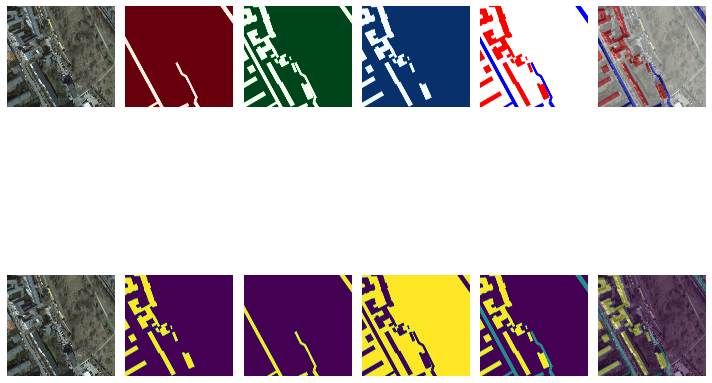

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(10, 10))

image = np.asarray(Image.open(all_dataset_dir / 'aerial' / 'Training' / 'images' / 'berlin10_image.png'))
label = np.asarray(Image.open(all_dataset_dir / 'aerial' / 'Training' / 'labels' / 'berlin10_labels.png'))

ax[0][0].imshow(image)
ax[0][1].imshow(label[:, :, 0], cmap='Reds')
ax[0][2].imshow(label[:, :, 1], cmap='Greens')
ax[0][3].imshow(label[:, :, 2], cmap='Blues')
ax[0][4].imshow(label)
ax[0][5].imshow(image)
ax[0][5].imshow(label, alpha=0.4)

red  = label[:, :, 0] - label[:, :, 1] - label[:, :, 2]
blue = label[:, :, 2] - label[:, :, 0] - label[:, :, 1]
bg   = np.ones_like(red) * 255 - red - blue + 2
newlabel = np.floor(red/85 + blue/128 + bg/255 - np.ones_like(bg)).astype(np.uint8)

ax[1][0].imshow(image)
ax[1][1].imshow(red)
ax[1][2].imshow(blue)
ax[1][3].imshow(bg)
ax[1][4].imshow(newlabel)
ax[1][5].imshow(image)
ax[1][5].imshow(newlabel, alpha=0.4)

for axr in ax:
    for axc in axr:
        axc.axis('off')
fig.tight_layout()
plt.show()

In [ ]:
np.unique(red), np.unique(blue), np.unique(bg), np.unique(label), np.unique(newlabel),

(array([  1, 255], dtype=uint8),
 array([  1, 255], dtype=uint8),
 array([  1, 255], dtype=uint8),
 array([  0, 255], dtype=uint8),
 array([0, 1, 2], dtype=uint8))

In [ ]:
newlabel.shape, image.shape

((2453, 2611), (2453, 2611, 3))

##### Data Generator

Number of training samples: 50


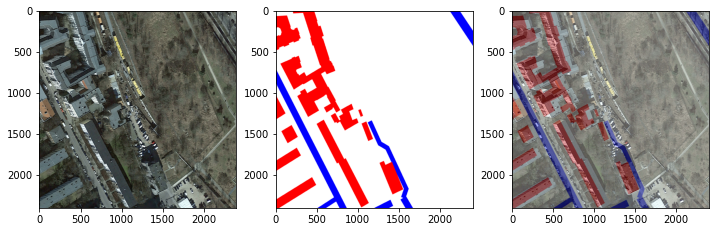

In [ ]:
class AerialImagesSequence(K.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size       = batch_size
        self.img_size         = img_size
        self.input_img_paths  = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, index):
        i = index * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = K.preprocessing.image.load_img(path, target_size=self.img_size)
            x[j] = np.asarray(img) / 255.
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            y[j] = (np.asarray(K.preprocessing.image.load_img(path, target_size=self.img_size)) / 255.).astype(np.uint8)
        return x, y


current_dataset_dir = all_dataset_dir / 'aerial'
input_img_paths     = sorted((current_dataset_dir / 'Training' / 'images').glob("*.png"))
target_img_paths    = sorted((current_dataset_dir / 'Training' / 'labels').glob("*.png"))
print(f"Number of training samples: {len(input_img_paths)}")

ds = AerialImagesSequence(4, (2400, 2400), input_img_paths, target_img_paths)
x, y = ds[0]
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(x[0])
ax[1].imshow(y[0])
ax[2].imshow(x[0])
ax[2].imshow(y[0], alpha=0.3)
plt.show()

In [ ]:
np.min(x), np.max(x), np.min(y), np.max(y), np.unique(y)

(0.0, 1.0, 0.0, 1.0, array([0., 1.], dtype=float32))

##### Model

In [ ]:
def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = L.SpatialDropout2D
    elif dropout_type == "standard":
        DO = L.Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = L.Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = L.normalization.BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = L.Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = L.normalization.BatchNormalization()(c)
    return c


def get_crop_shape(target, refer):
    # W: width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # H: height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)


def UNet(
    input_shape,
    num_classes=1,
    dropout=0.5,
    filters=64,
    num_layers=4,
    output_activation='sigmoid'): # 'sigmoid' or 'softmax'

    # Build U-Net model
    inputs = L.Input(input_shape)
    x = inputs

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=False, dropout=0.0, padding='valid')
        down_layers.append(x)
        x = L.MaxPooling2D((2, 2), strides=2) (x)
        filters = filters*2 # double the number of filters with each layer

    x = L.Dropout(dropout)(x)
    x = conv2d_block(inputs=x, filters=filters, use_batch_norm=False, dropout=0.0, padding='valid')

    for conv in reversed(down_layers):
        filters //= 2 # decreasing number of filters with each layer
        x = L.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='valid') (x)

        ch, cw = get_crop_shape(int_shape(conv), int_shape(x))
        conv = L.Cropping2D(cropping=(ch, cw))(conv)

        x = concatenate([x, conv])
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=False, dropout=0.0, padding='valid')

    outputs = Conv2D(num_classes, (1, 1), activation=output_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = UNet(input_shape=IMAGE_SIZE, num_classes=3, output_activation='softmax')
model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy', K.metrics.MeanIoU(num_classes=4)])
model.summary()

##### Training

In [ ]:
current_dataset_dir = all_dataset_dir / 'aerial'
input_img_paths     = sorted((current_dataset_dir / 'Training' / 'images').glob("*.png"))
target_img_paths    = sorted((current_dataset_dir / 'Training' / 'labels').glob("*.png"))
BATCH_SIZE          = 4
IMAGE_SIZE          = (2400, 2400)

traingen = AerialImagesSequence(BATCH_SIZE, IMAGE_SIZE, input_img_paths, target_img_paths)
model.fit(traingen,
          validation_split=0.2,
          epochs=250,
          verbose=1)

##### Inference

In [ ]:
Y_test_hat = model.predict(X_test)
sns.heatmap(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_test_hat, axis=1)), cmap="Greens")

## Q5

**2D depthwise separable convolution**

In [ ]:
# Copy Lenna image from GDrive to data/
shutil.copyfile(my_gdrive_dir / 'lenna_jpg.jpg', all_dataset_dir)

NameError: ignored

In [ ]:
import numpy as np
d_filt = np.array([[[1, 2, 1], [2, 4, 2], [1, 2, 1]],
                   [[1, 2, 1], [2, 4, 2], [1, 2, 1]],
                   [[1, 2, 1], [2, 4, 2], [1, 2, 1]]]) / 16.0
p_filt = np.array([[1], [1], [1]]) / 512.0

# TODO

In [ ]:
lenna = np.asarray(Image.open(dataset_dir / 'lenna_jpg.jpg'))
filt  = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16.0

# TODO

NameError: ignored

In [ ]:
# Two-dimensional depthwise convolution.

"""
input: input array with shape (height, width, in_depth)
w: filter array with shape (fd, fd, in_depth)
"""

def depthwise_conv2d(input, w):

    assert w.shape[0] == w.shape[1] and w.shape[0] % 2 == 1

    padw = w.shape[0] // 2
    padded_input = np.pad(input,
                          pad_width=((padw, padw), (padw, padw), (0, 0)),
                          mode='constant',
                          constant_values=0)

    height, width, in_depth = input.shape
    assert in_depth == w.shape[2]
    output = np.zeros((height, width, in_depth))

    for c in range(in_depth):
        # For each input channel separately, apply its corresponsing filter
        # to the input.
        for i in range(height):
            for j in range(width):
                for fi in range(w.shape[0]):
                    for fj in range(w.shape[1]):
                        w_element = w[fi, fj, c]
                        output[i, j, c] += (
                            padded_input[i + fi, j + fj, c] * w_element)
    return output #Returns a result with shape (height, width, in_depth).



# Depthwise separable convolution
'''
input: input array with shape (height, width, in_depth)
w_depth: depthwise filter array with shape (fd, fd, in_depth)
w_pointwise: pointwise filter array with shape (in_depth, out_depth)
'''
def separable_conv2d(input, w_depth, w_pointwise):

    # First run the depthwise convolution. Its result has the same shape as
    # input.
    depthwise_result = depthwise_conv2d(input, w_depth)

    height, width, in_depth = depthwise_result.shape
    assert in_depth == w_pointwise.shape[0]
    out_depth = w_pointwise.shape[1]
    output = np.zeros((height, width, out_depth))

    for out_c in range(out_depth):
        for i in range(height):
            for j in range(width):
                for c in range(in_depth):
                    w_element = w_pointwise[c, out_c]
                    output[i, j, out_c] += depthwise_result[i, j, c] * w_element
    return output # Returns a result with shape (height, width, out_depth).

In [ ]:
answer_2d_depth_sep = separable_conv2d(lenna, d_filt, p_filt)

NameError: ignored